In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, 
    RFE, SelectFromModel
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [2]:
# Cell 2: Load Raw Data and Apply Categorical Reconstruction

def load_raw_data():
    """Load raw data from CSV files"""
    try:
        print("Loading raw training data...")
        # Replace with your actual file paths
        train_data = pd.read_parquet('dataset/train_data_converted.parquet')  # Update with your train file path
        test_data = pd.read_parquet('dataset/test_data_converted.parquet')    # Update with your test file path
        
        print(f"✅ Raw data loaded successfully")
        print(f"Train data shape: {train_data.shape}")
        print(f"Test data shape: {test_data.shape}")
        
        return train_data, test_data
        
    except FileNotFoundError as e:
        print(f"❌ File not found: {str(e)}")
        print("Please update the file paths in the load_raw_data() function")
        return None, None
    except Exception as e:
        print(f"❌ Error loading data: {str(e)}")
        return None, None

def safe_check_one(value):
    """Safely check if value equals 1, handling NA values"""
    try:
        if pd.isna(value):
            return False
        numeric_value = pd.to_numeric(value, errors='coerce')
        if pd.isna(numeric_value):
            return False
        return numeric_value == 1
    except:
        return False

def reconstruct_categorical_features(data):
    """
    Convert one-hot encoded features back to single categorical features
    Based on your data dictionary analysis
    """
    print("Reconstructing categorical features...")
    reconstructed_data = data.copy()
    
    # Enhanced category names mapping
    offer_category_names = {
        'f226': 'Business',
        'f227': 'Dining',  
        'f228': 'Entertainment',
        'f229': 'Retail',
        'f230': 'Services',
        'f231': 'Shopping',
        'f232': 'Travel'
    }
    
    # Define feature mappings based on your data dictionary
    feature_mappings = {
        'offer_category': ['f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232'],
        'offer_subcategory': [f'f{i}' for i in range(233, 310)]  # f233 to f309
    }
    
    for category_name, feature_columns in feature_mappings.items():
        print(f"Processing {category_name}...")
        
        # Check which columns actually exist in the data
        existing_columns = [col for col in feature_columns if col in data.columns]
        
        if not existing_columns:
            print(f"⚠️ No columns found for {category_name}")
            reconstructed_data[category_name] = 'unknown'
            continue
        
        print(f"Found {len(existing_columns)} existing columns for {category_name}")
        
        # Create the categorical feature
        categorical_values = []
        
        for idx in range(len(data)):
            active_features = []
            for col in existing_columns:
                if safe_check_one(data[col].iloc[idx]):
                    # Use proper category names
                    if category_name == 'offer_category' and col in offer_category_names:
                        category_value = offer_category_names[col]
                    else:
                        category_value = col.replace('f', 'subcat_') if category_name == 'offer_subcategory' else col.replace('f', '')
                    active_features.append(category_value)
            
            # Handle multiple or no active features
            if len(active_features) == 0:
                categorical_values.append('unknown')
            elif len(active_features) == 1:
                categorical_values.append(active_features[0])
            else:
                categorical_values.append('_'.join(sorted(active_features)))
        
        # Add the reconstructed categorical feature
        reconstructed_data[category_name] = categorical_values
        
        # Show category distribution
        category_counts = pd.Series(categorical_values).value_counts()
        print(f"✅ Created {category_name} with {len(set(categorical_values))} unique values")
        print(f"Top 5 categories: {category_counts.head().to_dict()}")
        print()
    
    return reconstructed_data

def identify_feature_types(data):
    """Identify different types of features in the dataset"""
    print("=== FEATURE TYPE IDENTIFICATION ===")
    
    # ID columns
    id_columns = ['id1', 'id2', 'id3', 'id4', 'id5']
    
    # Target column
    target_column = 'y'
    
    # Reconstructed categorical columns
    categorical_columns = ['offer_category', 'offer_subcategory']
    
    # One-hot encoded columns that were reconstructed
    onehot_columns = []
    for i in range(226, 310):  # f226 to f309
        col_name = f'f{i}'
        if col_name in data.columns:
            onehot_columns.append(col_name)
    
    # Remaining numerical features
    all_columns = set(data.columns)
    used_columns = set(id_columns + [target_column] + categorical_columns + onehot_columns)
    numerical_columns = list(all_columns - used_columns)
    
    # Filter out any columns that don't exist
    numerical_columns = [col for col in numerical_columns if col in data.columns]
    
    feature_info = {
        'id_columns': id_columns,
        'target_column': target_column,
        'categorical_columns': categorical_columns,
        'onehot_columns': onehot_columns,
        'numerical_columns': numerical_columns
    }
    
    print(f"ID columns: {len(feature_info['id_columns'])}")
    print(f"Target column: 1")
    print(f"Categorical columns: {len(feature_info['categorical_columns'])}")
    print(f"One-hot encoded columns: {len(feature_info['onehot_columns'])}")
    print(f"Numerical columns: {len(feature_info['numerical_columns'])}")
    print(f"Total columns: {len(data.columns)}")
    
    return feature_info

# Load the raw data
train_data, test_data = load_raw_data()

if train_data is not None and test_data is not None:
    print(f"\n=== ORIGINAL DATA INFO ===")
    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    print(f"Target distribution in train: {train_data['y'].value_counts().to_dict()}")
    print(f"Click rate: {train_data['y'].mean():.4f}")
    
    # Apply categorical reconstruction to both datasets
    print(f"\n=== APPLYING CATEGORICAL RECONSTRUCTION ===")
    train_data_reconstructed = reconstruct_categorical_features(train_data)
    test_data_reconstructed = reconstruct_categorical_features(test_data)
    
    # Identify feature types
    feature_info = identify_feature_types(train_data_reconstructed)
    
    print(f"\n=== DATA AFTER RECONSTRUCTION ===")
    print(f"Train data shape: {train_data_reconstructed.shape}")
    print(f"Test data shape: {test_data_reconstructed.shape}")
    
    # Quick data quality check
    print(f"\n=== DATA QUALITY CHECK ===")
    print(f"Missing values in train: {train_data_reconstructed.isnull().sum().sum():,}")
    print(f"Missing values in test: {test_data_reconstructed.isnull().sum().sum():,}")
    
    # Show sample of reconstructed categorical features
    print(f"\n=== SAMPLE CATEGORICAL FEATURES ===")
    for cat_col in feature_info['categorical_columns']:
        if cat_col in train_data_reconstructed.columns:
            print(f"{cat_col} samples: {train_data_reconstructed[cat_col].head().tolist()}")
    
else:
    print("❌ Failed to load data. Please check file paths and try again.")


Loading raw training data...
✅ Raw data loaded successfully
Train data shape: (770164, 372)
Test data shape: (369301, 371)

=== ORIGINAL DATA INFO ===
Train data shape: (770164, 372)
Test data shape: (369301, 371)
Target distribution in train: {np.int8(0): 733113, np.int8(1): 37051}
Click rate: 0.0481

=== APPLYING CATEGORICAL RECONSTRUCTION ===
Reconstructing categorical features...
Processing offer_category...
Found 7 existing columns for offer_category
✅ Created offer_category with 13 unique values
Top 5 categories: {'Shopping': 618220, 'Services': 50843, 'Dining': 35593, 'Travel': 34747, 'Entertainment': 18186}

Processing offer_subcategory...
Found 77 existing columns for offer_subcategory
✅ Created offer_subcategory with 58 unique values
Top 5 categories: {'subcat_285': 450185, 'subcat_252': 61827, 'subcat_237': 31668, 'subcat_288': 18034, 'subcat_265': 17323}

Reconstructing categorical features...
Processing offer_category...
Found 7 existing columns for offer_category
✅ Create

=== MISSING VALUE ANALYSIS ===
Total features analyzed: 285
Features with missing values: 280
Features with >80% missing: 40
Features with 20-80% missing: 103
Features with <20% missing: 137
Complete features: 5


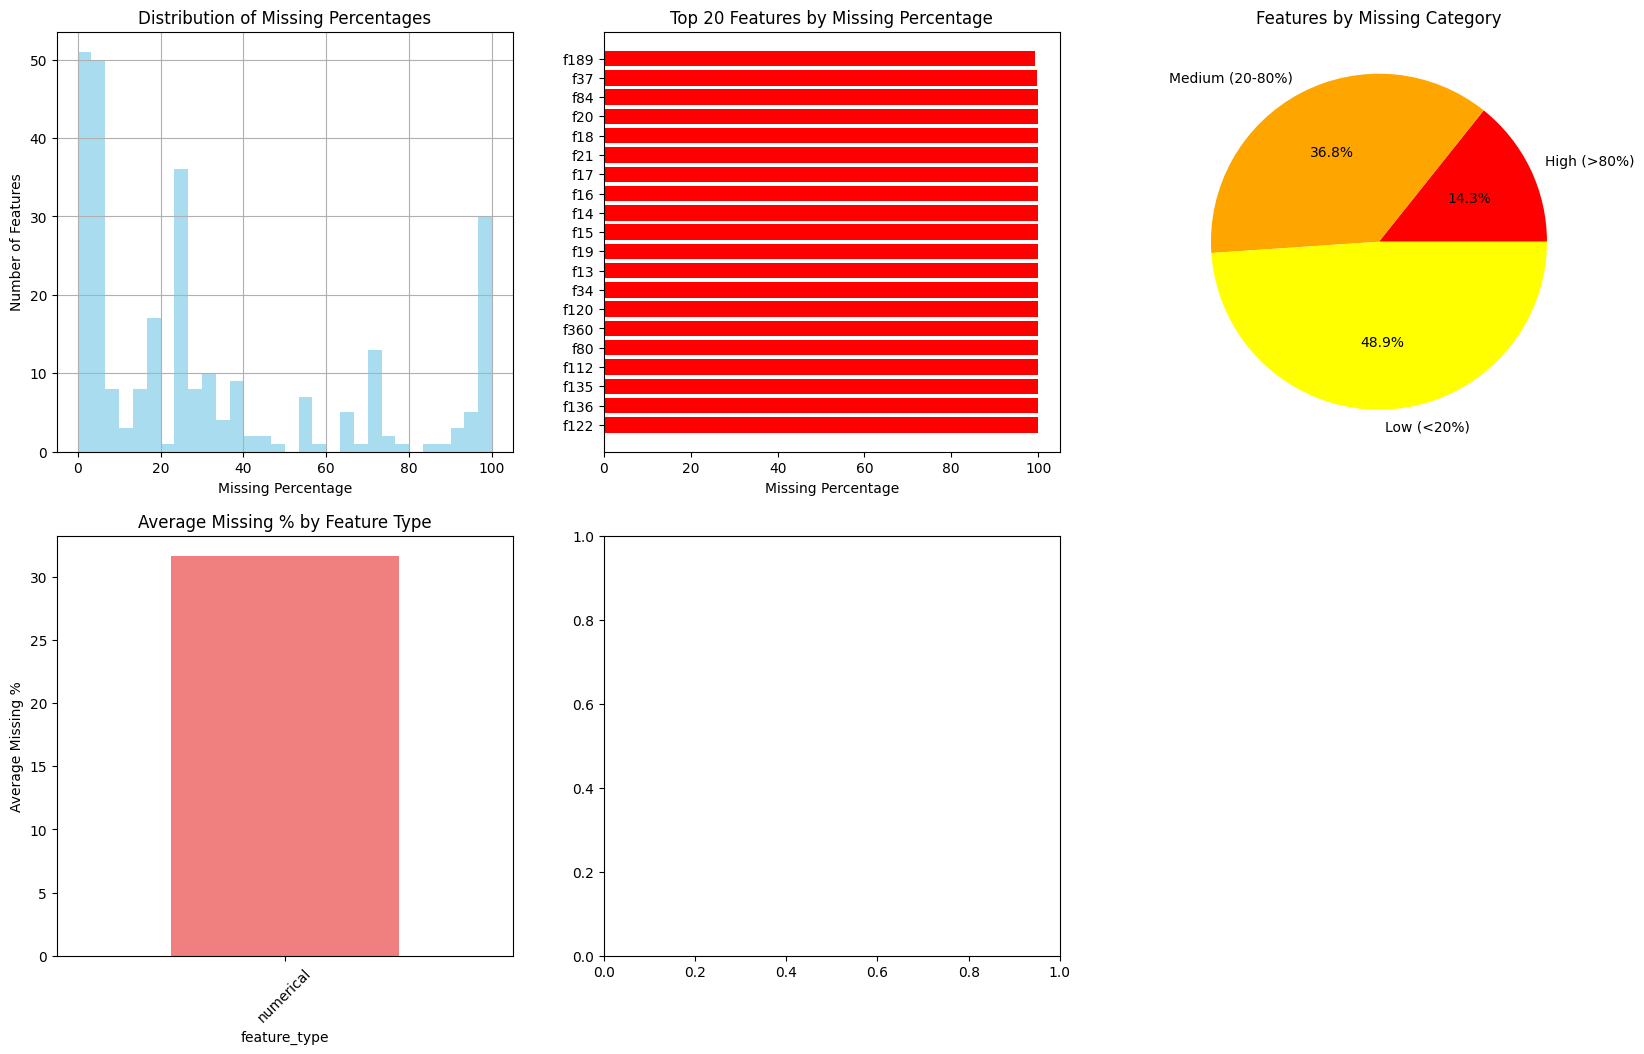

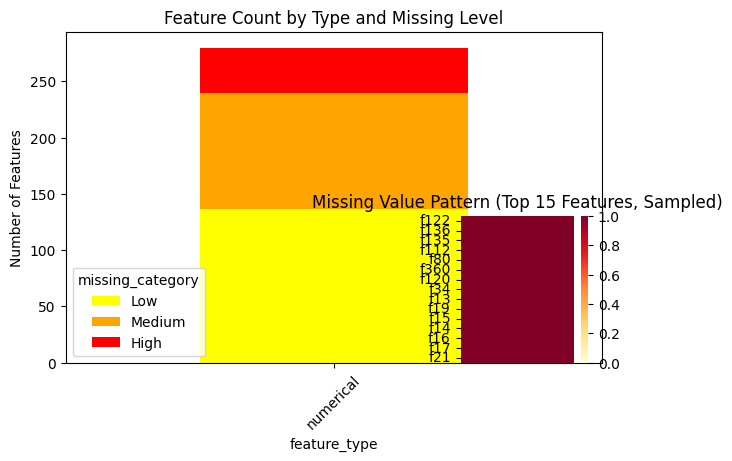


=== TOP 10 FEATURES WITH HIGHEST MISSING PERCENTAGES ===
    feature  missing_pct feature_type
243    f122   100.000000    numerical
7      f136   100.000000    numerical
153    f135   100.000000    numerical
156    f112   100.000000    numerical
147     f80    99.989872    numerical
191    f360    99.969877    numerical
108    f120    99.967150    numerical
130     f34    99.947544    numerical
88      f13    99.909630    numerical
186     f19    99.909630    numerical


In [3]:
# Cell 3: Missing Value Analysis (Updated to work with your data structure)

def analyze_missing_patterns_updated(data, feature_info):
    """Enhanced missing value analysis using feature type information"""
    print("=== MISSING VALUE ANALYSIS ===")
    
    # Focus on relevant columns for analysis
    analysis_columns = (feature_info['numerical_columns'] + 
                       feature_info['categorical_columns'] + 
                       [feature_info['target_column']])
    
    # Remove columns that don't exist
    analysis_columns = [col for col in analysis_columns if col in data.columns]
    
    missing_stats = pd.DataFrame({
        'feature': analysis_columns,
        'missing_count': [data[col].isnull().sum() for col in analysis_columns],
        'missing_pct': [(data[col].isnull().sum() / len(data)) * 100 for col in analysis_columns],
        'dtype': [data[col].dtype for col in analysis_columns],
        'unique_values': [data[col].nunique() for col in analysis_columns],
        'feature_type': ['categorical' if col in feature_info['categorical_columns'] 
                        else 'target' if col == feature_info['target_column']
                        else 'numerical' for col in analysis_columns]
    })
    
    # Filter out columns with no missing values for focused analysis
    missing_stats_filtered = missing_stats[missing_stats['missing_count'] > 0].sort_values(
        'missing_pct', ascending=False
    )
    
    # Categorize features by missing percentage
    high_missing = missing_stats_filtered[missing_stats_filtered['missing_pct'] > 80]
    medium_missing = missing_stats_filtered[
        (missing_stats_filtered['missing_pct'] > 20) & (missing_stats_filtered['missing_pct'] <= 80)
    ]
    low_missing = missing_stats_filtered[
        (missing_stats_filtered['missing_pct'] > 0) & (missing_stats_filtered['missing_pct'] <= 20)
    ]
    
    print(f"Total features analyzed: {len(analysis_columns)}")
    print(f"Features with missing values: {len(missing_stats_filtered)}")
    print(f"Features with >80% missing: {len(high_missing)}")
    print(f"Features with 20-80% missing: {len(medium_missing)}")
    print(f"Features with <20% missing: {len(low_missing)}")
    print(f"Complete features: {len(missing_stats) - len(missing_stats_filtered)}")
    
    # Enhanced visualization
    plt.figure(figsize=(20, 12))
    
    # Plot 1: Missing percentage distribution
    plt.subplot(2, 3, 1)
    if len(missing_stats_filtered) > 0:
        missing_stats_filtered['missing_pct'].hist(bins=30, alpha=0.7, color='skyblue')
        plt.title('Distribution of Missing Percentages')
        plt.xlabel('Missing Percentage')
        plt.ylabel('Number of Features')
    
    # Plot 2: Top missing features
    plt.subplot(2, 3, 2)
    if len(missing_stats_filtered) > 0:
        top_missing = missing_stats_filtered.head(20)
        colors = ['red' if x > 80 else 'orange' if x > 20 else 'yellow' for x in top_missing['missing_pct']]
        plt.barh(range(len(top_missing)), top_missing['missing_pct'], color=colors)
        plt.yticks(range(len(top_missing)), [f"{feat[:15]}" for feat in top_missing['feature']])
        plt.title('Top 20 Features by Missing Percentage')
        plt.xlabel('Missing Percentage')
    
    # Plot 3: Missing categories
    plt.subplot(2, 3, 3)
    category_counts = [len(high_missing), len(medium_missing), len(low_missing)]
    categories = ['High (>80%)', 'Medium (20-80%)', 'Low (<20%)']
    colors = ['red', 'orange', 'yellow']
    plt.pie(category_counts, labels=categories, autopct='%1.1f%%', colors=colors)
    plt.title('Features by Missing Category')
    
    # Plot 4: Missing by feature type
    plt.subplot(2, 3, 4)
    if len(missing_stats_filtered) > 0:
        missing_by_type = missing_stats_filtered.groupby('feature_type')['missing_pct'].mean()
        missing_by_type.plot(kind='bar', color='lightcoral')
        plt.title('Average Missing % by Feature Type')
        plt.ylabel('Average Missing %')
        plt.xticks(rotation=45)
    
    # Plot 5: Feature count by type and missing level
    plt.subplot(2, 3, 5)
    if len(missing_stats_filtered) > 0:
        missing_stats_filtered['missing_category'] = pd.cut(
            missing_stats_filtered['missing_pct'], 
            bins=[0, 20, 80, 100], 
            labels=['Low', 'Medium', 'High']
        )
        feature_type_missing = pd.crosstab(
            missing_stats_filtered['feature_type'], 
            missing_stats_filtered['missing_category']
        )
        feature_type_missing.plot(kind='bar', stacked=True, color=['yellow', 'orange', 'red'])
        plt.title('Feature Count by Type and Missing Level')
        plt.ylabel('Number of Features')
        plt.xticks(rotation=45)
    
    # Plot 6: Missing pattern heatmap for top features
    plt.subplot(2, 3, 6)
    if len(missing_stats_filtered) >= 10:
        top_missing_features = missing_stats_filtered.head(15)['feature'].tolist()
        # Sample data for heatmap (take every 1000th row for performance)
        sample_indices = range(0, len(data), max(1, len(data)//1000))
        missing_matrix = data.iloc[sample_indices][top_missing_features].isnull()
        sns.heatmap(missing_matrix.T, cbar=True, yticklabels=True, xticklabels=False, cmap='YlOrRd')
        plt.title('Missing Value Pattern (Top 15 Features, Sampled)')
    
    plt.tight_layout()
    plt.show()
    
    return missing_stats, high_missing, medium_missing, low_missing

# Apply the updated missing value analysis
if 'train_data_reconstructed' in locals():
    missing_stats, high_missing, medium_missing, low_missing = analyze_missing_patterns_updated(
        train_data_reconstructed, feature_info
    )
    
    print("\n=== TOP 10 FEATURES WITH HIGHEST MISSING PERCENTAGES ===")
    if len(missing_stats[missing_stats['missing_count'] > 0]) > 0:
        top_missing = missing_stats[missing_stats['missing_count'] > 0].sort_values('missing_pct', ascending=False)
        print(top_missing.head(10)[['feature', 'missing_pct', 'feature_type']])
    else:
        print("No missing values found in the dataset!")
else:
    print("❌ Please run Cell 2 first to load and reconstruct the data.")


In [4]:
# Cell 4: Fixed Missing Value Imputation Strategy

class SmartImputer:
    def __init__(self, missing_stats):
        self.missing_stats = missing_stats
        self.imputers = {}
        self.categorical_cols = ['offer_category', 'offer_subcategory']
        
    def identify_column_types(self, data):
        """Identify categorical vs numerical columns"""
        categorical_columns = []
        numerical_columns = []
        
        for col in data.columns:
            if col in ['y', 'id1', 'id2', 'id3', 'id4', 'id5']:
                continue
            if col in self.categorical_cols:
                categorical_columns.append(col)
            elif data[col].dtype == 'object' or data[col].dtype.name == 'category':
                categorical_columns.append(col)
            else:
                # Check if column contains mostly non-numeric values
                try:
                    pd.to_numeric(data[col], errors='coerce').dropna()
                    numerical_columns.append(col)
                except:
                    categorical_columns.append(col)
        
        return categorical_columns, numerical_columns
        
    def fit_transform_imputation(self, train_data, test_data):
        """Apply tiered imputation strategy with proper column type handling"""
        print("=== APPLYING SMART IMPUTATION ===")
        
        train_imputed = train_data.copy()
        test_imputed = test_data.copy()
        
        # Identify column types
        categorical_columns, numerical_columns = self.identify_column_types(train_imputed)
        print(f"Identified {len(categorical_columns)} categorical columns")
        print(f"Identified {len(numerical_columns)} numerical columns")
        
        # Identify feature categories by missing percentage
        high_missing_cols = self.missing_stats[
            self.missing_stats['missing_pct'] > 80
        ]['feature'].tolist()
        
        medium_missing_cols = self.missing_stats[
            (self.missing_stats['missing_pct'] > 20) & 
            (self.missing_stats['missing_pct'] <= 80)
        ]['feature'].tolist()
        
        low_missing_cols = self.missing_stats[
            (self.missing_stats['missing_pct'] > 0) & 
            (self.missing_stats['missing_pct'] <= 20)
        ]['feature'].tolist()
        
        # Remove ID columns and target from imputation
        exclude_cols = ['y', 'id1', 'id2', 'id3', 'id4', 'id5'] + self.categorical_cols
        
        high_missing_cols = [col for col in high_missing_cols if col not in exclude_cols]
        medium_missing_cols = [col for col in medium_missing_cols if col not in exclude_cols]
        low_missing_cols = [col for col in low_missing_cols if col not in exclude_cols]
        
        print(f"High missing features to process: {len(high_missing_cols)}")
        print(f"Medium missing features to process: {len(medium_missing_cols)}")
        print(f"Low missing features to process: {len(low_missing_cols)}")
        
        # Step 1: High missing features - Create indicators and impute appropriately
        print("\n1. Processing high missing features...")
        for col in high_missing_cols:
            if col in train_imputed.columns:
                # Create missing indicator
                train_imputed[f'{col}_missing'] = train_imputed[col].isnull().astype(int)
                test_imputed[f'{col}_missing'] = test_imputed[col].isnull().astype(int)
                
                # Impute based on column type
                if col in categorical_columns:
                    mode_val = train_imputed[col].mode()
                    if len(mode_val) > 0:
                        fill_val = mode_val.iloc[0]
                    else:
                        fill_val = 'unknown'
                else:
                    fill_val = train_imputed[col].median()
                    if pd.isna(fill_val):
                        fill_val = 0
                
                train_imputed[col].fillna(fill_val, inplace=True)
                test_imputed[col].fillna(fill_val, inplace=True)
        
        # Step 2: Medium missing features - Handle separately by type
        print("\n2. Processing medium missing features...")
        
        # Separate medium missing by type
        medium_numerical = [col for col in medium_missing_cols if col in numerical_columns]
        medium_categorical = [col for col in medium_missing_cols if col in categorical_columns]
        
        # Handle numerical medium missing with iterative imputation
        if medium_numerical:
            try:
                # Limit to top 15 numerical features for efficiency
                iterative_cols = medium_numerical[:15]
                
                iterative_imputer = IterativeImputer(
                    random_state=42, 
                    max_iter=5,  # Reduced iterations for efficiency
                    initial_strategy='median'
                )
                
                # Fit on train and transform both
                train_subset = train_imputed[iterative_cols].copy()
                test_subset = test_imputed[iterative_cols].copy()
                
                train_imputed[iterative_cols] = iterative_imputer.fit_transform(train_subset)
                test_imputed[iterative_cols] = iterative_imputer.transform(test_subset)
                
                self.imputers['iterative'] = iterative_imputer
                
                # For remaining numerical medium missing features, use median
                remaining_numerical = [col for col in medium_numerical if col not in iterative_cols]
                for col in remaining_numerical:
                    median_val = train_imputed[col].median()
                    if pd.isna(median_val):
                        median_val = 0
                    train_imputed[col].fillna(median_val, inplace=True)
                    test_imputed[col].fillna(median_val, inplace=True)
                    
            except Exception as e:
                print(f"⚠️ Iterative imputation failed: {str(e)}, using median instead")
                for col in medium_numerical:
                    median_val = train_imputed[col].median()
                    if pd.isna(median_val):
                        median_val = 0
                    train_imputed[col].fillna(median_val, inplace=True)
                    test_imputed[col].fillna(median_val, inplace=True)
        
        # Handle categorical medium missing with mode
        for col in medium_categorical:
            mode_val = train_imputed[col].mode()
            if len(mode_val) > 0:
                fill_val = mode_val.iloc[0]
            else:
                fill_val = 'unknown'
            train_imputed[col].fillna(fill_val, inplace=True)
            test_imputed[col].fillna(fill_val, inplace=True)
        
        # Step 3: Low missing features - Simple imputation by type
        print("\n3. Processing low missing features...")
        for col in low_missing_cols:
            if col in categorical_columns:
                mode_val = train_imputed[col].mode()
                if len(mode_val) > 0:
                    fill_val = mode_val.iloc[0]
                else:
                    fill_val = 'unknown'
            else:
                fill_val = train_imputed[col].median()
                if pd.isna(fill_val):
                    fill_val = 0
            
            train_imputed[col].fillna(fill_val, inplace=True)
            test_imputed[col].fillna(fill_val, inplace=True)
        
        # Step 4: Handle reconstructed categorical features
        print("\n4. Processing reconstructed categorical features...")
        for col in self.categorical_cols:
            if col in train_imputed.columns:
                mode_val = train_imputed[col].mode()
                if len(mode_val) > 0:
                    fill_val = mode_val.iloc[0]
                else:
                    fill_val = 'unknown'
                train_imputed[col].fillna(fill_val, inplace=True)
                test_imputed[col].fillna(fill_val, inplace=True)
        
        print("✅ Imputation completed")
        return train_imputed, test_imputed

# Apply imputation
imputer = SmartImputer(missing_stats)
train_imputed, test_imputed = imputer.fit_transform_imputation(train_data_reconstructed, test_data_reconstructed)

# Verify imputation
print(f"\nMissing values after imputation:")
print(f"Train: {train_imputed.isnull().sum().sum()}")
print(f"Test: {test_imputed.isnull().sum().sum()}")

# Show summary by column type
categorical_cols, numerical_cols = imputer.identify_column_types(train_imputed)
print(f"\nFinal data summary:")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")
print(f"Total columns: {train_imputed.shape[1]}")


=== APPLYING SMART IMPUTATION ===
Identified 14 categorical columns
Identified 354 numerical columns
High missing features to process: 40
Medium missing features to process: 103
Low missing features to process: 137

1. Processing high missing features...

2. Processing medium missing features...

3. Processing low missing features...

4. Processing reconstructed categorical features...
✅ Imputation completed

Missing values after imputation:
Train: 1512
Test: 672

Final data summary:
Categorical columns: 14
Numerical columns: 394
Total columns: 414


In [5]:
# Cell 5: Smart Categorical Encoding

class CategoricalEncoder:
    def __init__(self):
        self.encoders = {}
        self.encoding_strategy = {}
        
    def fit_transform_categorical(self, train_data, test_data, target_col='y'):
        """Apply optimal encoding based on cardinality"""
        print("=== CATEGORICAL ENCODING ===")
        
        train_encoded = train_data.copy()
        test_encoded = test_data.copy()
        
        categorical_cols = ['offer_category', 'offer_subcategory']
        
        for col in categorical_cols:
            if col not in train_data.columns:
                continue
                
            print(f"\nProcessing {col}...")
            unique_count = train_data[col].nunique()
            print(f"Unique values: {unique_count}")
            
            if unique_count <= 10:
                # Low cardinality - One-hot encoding
                print(f"Applying one-hot encoding to {col}")
                train_encoded = pd.get_dummies(train_encoded, columns=[col], prefix=col)
                test_encoded = pd.get_dummies(test_encoded, columns=[col], prefix=col)
                
                # Ensure same columns in both datasets
                train_cols = set(train_encoded.columns)
                test_cols = set(test_encoded.columns)
                
                # Add missing columns with zeros
                for missing_col in train_cols - test_cols:
                    test_encoded[missing_col] = 0
                for missing_col in test_cols - train_cols:
                    train_encoded[missing_col] = 0
                
                # Reorder columns
                common_cols = sorted(list(train_cols.intersection(test_cols)))
                other_cols = [c for c in train_encoded.columns if c not in common_cols]
                train_encoded = train_encoded[other_cols + common_cols]
                test_encoded = test_encoded[other_cols + common_cols]
                
                self.encoding_strategy[col] = 'one_hot'
                
            elif unique_count <= 50:
                # Medium cardinality - Target encoding with smoothing
                print(f"Applying target encoding to {col}")
                
                # Calculate target mean by category
                target_mean = train_data.groupby(col)[target_col].mean()
                global_mean = train_data[target_col].mean()
                
                # Add smoothing to prevent overfitting
                counts = train_data.groupby(col).size()
                smoothing_factor = 1.0 / (1 + np.exp(-(counts - 1) / 25))
                
                target_encoded = target_mean * smoothing_factor + global_mean * (1 - smoothing_factor)
                
                # Apply encoding
                train_encoded[f'{col}_target_encoded'] = train_data[col].map(target_encoded)
                test_encoded[f'{col}_target_encoded'] = test_data[col].map(target_encoded)
                
                # Fill missing mappings with global mean
                train_encoded[f'{col}_target_encoded'].fillna(global_mean, inplace=True)
                test_encoded[f'{col}_target_encoded'].fillna(global_mean, inplace=True)
                
                # Remove original column
                train_encoded.drop(columns=[col], inplace=True)
                test_encoded.drop(columns=[col], inplace=True)
                
                self.encoders[col] = target_encoded
                self.encoding_strategy[col] = 'target_encoded'
                
            else:
                # High cardinality - Frequency encoding
                print(f"Applying frequency encoding to {col}")
                
                freq_encoding = train_data[col].value_counts().to_dict()
                
                train_encoded[f'{col}_frequency'] = train_data[col].map(freq_encoding)
                test_encoded[f'{col}_frequency'] = test_data[col].map(freq_encoding)
                
                # Fill missing mappings with 1 (lowest frequency)
                train_encoded[f'{col}_frequency'].fillna(1, inplace=True)
                test_encoded[f'{col}_frequency'].fillna(1, inplace=True)
                
                # Remove original column
                train_encoded.drop(columns=[col], inplace=True)
                test_encoded.drop(columns=[col], inplace=True)
                
                self.encoders[col] = freq_encoding
                self.encoding_strategy[col] = 'frequency'
        
        print("✅ Categorical encoding completed")
        return train_encoded, test_encoded

# Apply categorical encoding
cat_encoder = CategoricalEncoder()
train_encoded, test_encoded = cat_encoder.fit_transform_categorical(train_imputed, test_imputed)

print(f"\nData shape after encoding:")
print(f"Train: {train_encoded.shape}")
print(f"Test: {test_encoded.shape}")
print(f"\nEncoding strategies applied: {cat_encoder.encoding_strategy}")


=== CATEGORICAL ENCODING ===

Processing offer_category...
Unique values: 13
Applying target encoding to offer_category

Processing offer_subcategory...
Unique values: 58
Applying frequency encoding to offer_subcategory
✅ Categorical encoding completed

Data shape after encoding:
Train: (770164, 414)
Test: (369301, 413)

Encoding strategies applied: {'offer_category': 'target_encoded', 'offer_subcategory': 'frequency'}


In [6]:
# Cell 6: Feature Selection - Filter Methods (FIXED for Categorical fillna)

class FeatureSelector:
    def __init__(self):
        self.selectors = {}
        self.selected_features = {}
        self.categorical_cols = ['offer_category', 'offer_subcategory']
        self.encoders = {}
    
    def safe_fillna_categorical(self, series, fill_value='MISSING'):
        """Safely fill missing values in categorical columns"""
        if pd.api.types.is_categorical_dtype(series):
            if fill_value not in series.cat.categories:
                series = series.cat.add_categories([fill_value])
            return series.fillna(fill_value)
        else:
            return series.fillna(fill_value)
        
    def identify_all_categorical_columns(self, data):
        """Comprehensive identification of categorical columns"""
        categorical_columns = []
        
        for col in data.columns:
            # Skip ID and target columns
            if col in ['y', 'id1', 'id2', 'id3', 'id4', 'id5']:
                continue
                
            # Check if it's object/string dtype
            if data[col].dtype == 'object':
                categorical_columns.append(col)
            # Check if it's categorical dtype
            elif data[col].dtype.name == 'category':
                categorical_columns.append(col)
            # Check for known categorical columns
            elif col in self.categorical_cols:
                categorical_columns.append(col)
            # Check if it has very few unique values and contains strings
            elif data[col].nunique() < 50:
                # Sample some values to check if they're strings
                sample_values = data[col].dropna().head(100)
                if len(sample_values) > 0:
                    try:
                        # Try to convert to numeric
                        pd.to_numeric(sample_values.iloc[0])
                    except (ValueError, TypeError):
                        categorical_columns.append(col)
        
        return categorical_columns
        
    def prepare_data_for_selection(self, train_data, test_data):
        """Prepare data by encoding ALL categorical features for selection"""
        print("Preparing data for feature selection with safe categorical handling...")
        
        # Identify ALL categorical columns
        categorical_features = self.identify_all_categorical_columns(train_data)
        
        # Get numerical columns (exclude categorical, target, and ID columns)
        exclude_cols = categorical_features + ['y', 'id1', 'id2', 'id3', 'id4', 'id5']
        numerical_features = [col for col in train_data.columns if col not in exclude_cols]
        
        print(f"Categorical features found: {len(categorical_features)}")
        print(f"Numerical features found: {len(numerical_features)}")
        
        if len(categorical_features) > 0:
            print(f"Categorical columns: {categorical_features[:10]}...")  # Show first 10
        
        # Start with numerical features
        X_train_prep = train_data[numerical_features].copy()
        X_test_prep = test_data[numerical_features].copy()
        
        # Encode categorical features using safe fillna
        from sklearn.preprocessing import LabelEncoder
        
        for col in categorical_features:
            if col in train_data.columns:
                print(f"Encoding categorical column: {col}")
                le = LabelEncoder()
                
                # Use safe fillna for categorical columns
                train_values = self.safe_fillna_categorical(train_data[col], 'MISSING').astype(str)
                test_values = self.safe_fillna_categorical(test_data[col], 'MISSING').astype(str)
                
                # Combine train and test to ensure consistent encoding
                combined = pd.concat([train_values, test_values], ignore_index=True)
                le.fit(combined)
                
                # Transform and add to prepared data
                X_train_prep[f'{col}_encoded'] = le.transform(train_values)
                X_test_prep[f'{col}_encoded'] = le.transform(test_values)
                
                # Store encoder for later use
                self.encoders[col] = le
        
        # Handle any remaining non-numeric columns
        non_numeric_cols = [col for col in X_train_prep.columns if X_train_prep[col].dtype == 'object']
        
        if non_numeric_cols:
            print(f"⚠️ Warning: Non-numeric columns found and will be converted: {non_numeric_cols}")
            for col in non_numeric_cols:
                try:
                    X_train_prep[col] = pd.to_numeric(X_train_prep[col], errors='coerce')
                    X_test_prep[col] = pd.to_numeric(X_test_prep[col], errors='coerce')
                except:
                    print(f"⚠️ Dropping problematic column: {col}")
                    X_train_prep.drop(columns=[col], inplace=True)
                    X_test_prep.drop(columns=[col], inplace=True)
        
        # Fill any NaN values that might have been created
        X_train_prep = X_train_prep.fillna(0)
        X_test_prep = X_test_prep.fillna(0)
        
        # Final validation
        print(f"Final prepared data shape - Train: {X_train_prep.shape}, Test: {X_test_prep.shape}")
        print(f"Data types check:")
        print(f"Train - Object columns: {(X_train_prep.dtypes == 'object').sum()}")
        print(f"Test - Object columns: {(X_test_prep.dtypes == 'object').sum()}")
        
        return X_train_prep, X_test_prep
        
    def filter_methods_selection(self, X_train, y_train, X_test):
        """Apply multiple filter methods for feature selection"""
        print("=== FEATURE SELECTION - FILTER METHODS ===")
        
        print(f"Starting with {X_train.shape[1]} features")
        
        # Ensure data is numpy array and numeric
        if hasattr(X_train, 'values'):
            X_train = X_train.values
        if hasattr(X_test, 'values'):
            X_test = X_test.values
            
        # Convert to float to avoid any type issues
        X_train = X_train.astype(np.float64)
        X_test = X_test.astype(np.float64)
        
        # Step 1: Remove low variance features
        print("\n1. Removing low variance features...")
        variance_threshold = VarianceThreshold(threshold=0.01)
        X_train_var = variance_threshold.fit_transform(X_train)
        X_test_var = variance_threshold.transform(X_test)
        
        variance_features = variance_threshold.get_support(indices=True)
        print(f"Features after variance filtering: {X_train_var.shape[1]}")
        
        # Step 2: Univariate feature selection (F-test)
        print("\n2. Applying F-test selection...")
        k_best_f = min(300, X_train_var.shape[1] // 2)
        f_selector = SelectKBest(f_classif, k=k_best_f)
        X_train_f = f_selector.fit_transform(X_train_var, y_train)
        X_test_f = f_selector.transform(X_test_var)
        
        f_features = f_selector.get_support(indices=True)
        print(f"Features after F-test: {X_train_f.shape[1]}")
        
        # Step 3: Mutual Information selection
        print("\n3. Applying Mutual Information selection...")
        k_best_mi = min(200, X_train_f.shape[1])
        mi_selector = SelectKBest(mutual_info_classif, k=k_best_mi)
        X_train_mi = mi_selector.fit_transform(X_train_f, y_train)
        X_test_mi = mi_selector.transform(X_test_f)
        
        mi_features = mi_selector.get_support(indices=True)
        print(f"Features after Mutual Information: {X_train_mi.shape[1]}")
        
        # Store selectors
        self.selectors['variance'] = variance_threshold
        self.selectors['f_test'] = f_selector
        self.selectors['mutual_info'] = mi_selector
        
        # Map back to original feature indices
        final_features = variance_features[f_features[mi_features]]
        
        return X_train_mi, X_test_mi, final_features
    
    def tree_based_selection(self, X_train, y_train, X_test, max_features=150):
        """Tree-based feature importance selection"""
        print(f"\n4. Applying tree-based feature selection...")
        
        # Random Forest for feature importance
        rf_selector = RandomForestClassifier(
            n_estimators=100, 
            random_state=42, 
            n_jobs=-1,
            max_depth=10
        )
        rf_selector.fit(X_train, y_train)
        
        # Get feature importance
        feature_importance = pd.DataFrame({
            'feature_idx': range(len(rf_selector.feature_importances_)),
            'importance': rf_selector.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Select top features
        n_features = min(max_features, len(feature_importance))
        top_features_idx = feature_importance.head(n_features)['feature_idx'].tolist()
        
        X_train_rf = X_train[:, top_features_idx]
        X_test_rf = X_test[:, top_features_idx]
        
        print(f"Features after RF importance: {X_train_rf.shape[1]}")
        
        # Store selector and importance scores
        self.selectors['random_forest'] = rf_selector
        self.selected_features['rf_importance'] = feature_importance
        
        return X_train_rf, X_test_rf, top_features_idx
    
    def correlation_filtering(self, X_train, threshold=0.95):
        """Remove highly correlated features"""
        print(f"\n5. Removing highly correlated features (threshold={threshold})...")
        
        # Calculate correlation matrix
        corr_matrix = np.corrcoef(X_train.T)
        
        # Find highly correlated feature pairs
        high_corr_pairs = []
        for i in range(len(corr_matrix)):
            for j in range(i+1, len(corr_matrix)):
                if abs(corr_matrix[i, j]) > threshold:
                    high_corr_pairs.append((i, j, corr_matrix[i, j]))
        
        # Remove features with high correlation (keep first occurrence)
        features_to_remove = set()
        for i, j, corr in high_corr_pairs:
            features_to_remove.add(j)  # Remove second feature
        
        features_to_keep = [i for i in range(X_train.shape[1]) if i not in features_to_remove]
        
        print(f"Removed {len(features_to_remove)} highly correlated features")
        print(f"Remaining features: {len(features_to_keep)}")
        
        return features_to_keep

# Apply the fixed feature selection
print("Starting feature selection...")
feature_selector = FeatureSelector()

# Prepare data with proper categorical encoding using safe fillna
X_train_prep, X_test_prep = feature_selector.prepare_data_for_selection(train_encoded, test_encoded)

# Extract target
y_train = train_encoded['y'].values

print(f"Starting feature selection with {X_train_prep.shape[1]} features")

# Apply feature selection
X_train_filtered, X_test_filtered, filtered_features = feature_selector.filter_methods_selection(
    X_train_prep, y_train, X_test_prep
)

# Tree-based selection
X_train_tree, X_test_tree, tree_features = feature_selector.tree_based_selection(
    X_train_filtered, y_train, X_test_filtered
)

# Correlation filtering
corr_features = feature_selector.correlation_filtering(X_train_tree)
X_train_corr = X_train_tree[:, corr_features]
X_test_corr = X_test_tree[:, corr_features]

print(f"\nFinal feature count after filter methods: {X_train_corr.shape[1]}")


Starting feature selection...
Preparing data for feature selection with safe categorical handling...
Categorical features found: 12
Numerical features found: 396
Categorical columns: ['f42', 'f48', 'f50', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f218']...
Encoding categorical column: f42
Encoding categorical column: f48
Encoding categorical column: f50
Encoding categorical column: f52
Encoding categorical column: f53
Encoding categorical column: f54
Encoding categorical column: f55
Encoding categorical column: f56
Encoding categorical column: f57
Encoding categorical column: f218
Encoding categorical column: f349
Encoding categorical column: f354
Final prepared data shape - Train: (770164, 408), Test: (369301, 408)
Data types check:
Train - Object columns: 0
Test - Object columns: 0
Starting feature selection with 408 features
=== FEATURE SELECTION - FILTER METHODS ===
Starting with 408 features

1. Removing low variance features...
Features after variance filtering: 243

2. Applying

In [7]:
# Cell 7: Wrapper Methods and Final Feature Selection

def wrapper_feature_selection(X_train, y_train, X_test, n_features_final=100):
    """Apply wrapper methods for final feature selection"""
    print("=== WRAPPER METHODS FEATURE SELECTION ===")
    
    # Recursive Feature Elimination with Cross-Validation
    print(f"\nApplying RFE to select {n_features_final} features...")
    
    # Use Logistic Regression as estimator (good for ranking tasks)
    estimator = LogisticRegression(
        random_state=42, 
        max_iter=1000, 
        solver='liblinear'
    )
    
    rfe_selector = RFE(
        estimator=estimator, 
        n_features_to_select=n_features_final,
        step=0.1  # Remove 10% of features at each step
    )
    
    # Fit RFE
    X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
    X_test_rfe = rfe_selector.transform(X_test)
    
    # Get selected feature indices
    selected_features = rfe_selector.get_support(indices=True)
    
    print(f"✅ RFE completed. Selected {X_train_rfe.shape[1]} features")
    
    # Feature ranking
    feature_ranking = pd.DataFrame({
        'feature_idx': range(len(rfe_selector.ranking_)),
        'ranking': rfe_selector.ranking_,
        'selected': rfe_selector.support_
    }).sort_values('ranking')
    
    print(f"Top 10 features by RFE ranking:")
    print(feature_ranking.head(10))
    
    return X_train_rfe, X_test_rfe, selected_features, rfe_selector

# Apply wrapper methods
X_train_final, X_test_final, final_feature_indices, rfe_selector = wrapper_feature_selection(
    X_train_corr, y_train, X_test_corr, n_features_final=100
)

print(f"\nFinal dataset shape:")
print(f"X_train_final: {X_train_final.shape}")
print(f"X_test_final: {X_test_final.shape}")


=== WRAPPER METHODS FEATURE SELECTION ===

Applying RFE to select 100 features...
✅ RFE completed. Selected 100 features
Top 10 features by RFE ranking:
    feature_idx  ranking  selected
0             0        1      True
72           72        1      True
71           71        1      True
70           70        1      True
69           69        1      True
68           68        1      True
67           67        1      True
66           66        1      True
65           65        1      True
64           64        1      True

Final dataset shape:
X_train_final: (770164, 100)
X_test_final: (369301, 100)


In [8]:
# Cell 8: Advanced Feature Engineering

def create_advanced_features(X_train, X_test, y_train):
    """Create advanced features for better ranking performance"""
    print("=== ADVANCED FEATURE ENGINEERING ===")
    
    X_train_advanced = X_train.copy()
    X_test_advanced = X_test.copy()
    
    # 1. Statistical features
    print("1. Creating statistical features...")
    
    # Row-wise statistics
    X_train_advanced = np.column_stack([
        X_train_advanced,
        np.mean(X_train, axis=1),      # Row mean
        np.std(X_train, axis=1),       # Row std
        np.min(X_train, axis=1),       # Row min
        np.max(X_train, axis=1),       # Row max
        np.median(X_train, axis=1)     # Row median
    ])
    
    X_test_advanced = np.column_stack([
        X_test_advanced,
        np.mean(X_test, axis=1),
        np.std(X_test, axis=1),
        np.min(X_test, axis=1),
        np.max(X_test, axis=1),
        np.median(X_test, axis=1)
    ])
    
    # 2. Interaction features (top features only)
    print("2. Creating interaction features...")
    
    # Select top 10 features for interactions
    if X_train.shape[1] >= 10:
        top_features = range(10)
        
        for i in range(len(top_features)):
            for j in range(i+1, min(i+3, len(top_features))):  # Limit interactions
                # Multiplicative interaction
                interaction_train = X_train[:, i] * X_train[:, j]
                interaction_test = X_test[:, i] * X_test[:, j]
                
                X_train_advanced = np.column_stack([X_train_advanced, interaction_train])
                X_test_advanced = np.column_stack([X_test_advanced, interaction_test])
    
    # 3. Polynomial features (degree 2) for selected features
    print("3. Creating polynomial features...")
    
    if X_train.shape[1] >= 5:
        top_poly_features = range(5)
        
        for i in top_poly_features:
            # Squared features
            poly_train = X_train[:, i] ** 2
            poly_test = X_test[:, i] ** 2
            
            X_train_advanced = np.column_stack([X_train_advanced, poly_train])
            X_test_advanced = np.column_stack([X_test_advanced, poly_test])
    
    print(f"Advanced features shape: Train {X_train_advanced.shape}, Test {X_test_advanced.shape}")
    
    return X_train_advanced, X_test_advanced

# Create advanced features
X_train_engineered, X_test_engineered = create_advanced_features(
    X_train_final, X_test_final, y_train
)


=== ADVANCED FEATURE ENGINEERING ===
1. Creating statistical features...
2. Creating interaction features...
3. Creating polynomial features...
Advanced features shape: Train (770164, 127), Test (369301, 127)


In [9]:
# Cell 9: Feature Scaling and Final Preprocessing

def final_preprocessing(X_train, X_test, scaling_method='standard'):
    """Apply final preprocessing steps"""
    print("=== FINAL PREPROCESSING ===")
    
    # 1. Handle any remaining infinite or very large values
    print("1. Handling extreme values...")
    
    # Replace infinite values
    X_train = np.nan_to_num(X_train, nan=0, posinf=1e6, neginf=-1e6)
    X_test = np.nan_to_num(X_test, nan=0, posinf=1e6, neginf=-1e6)
    
    # 2. Feature scaling
    print(f"2. Applying {scaling_method} scaling...")
    
    if scaling_method == 'standard':
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        # No scaling
        X_train_scaled = X_train
        X_test_scaled = X_test
        scaler = None
    
    # 3. Final validation
    print("3. Final validation...")
    
    print(f"Final train shape: {X_train_scaled.shape}")
    print(f"Final test shape: {X_test_scaled.shape}")
    print(f"Train data range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
    print(f"Test data range: [{X_test_scaled.min():.3f}, {X_test_scaled.max():.3f}]")
    
    # Check for any issues
    train_issues = {
        'has_nan': np.isnan(X_train_scaled).any(),
        'has_inf': np.isinf(X_train_scaled).any(),
        'all_zero_features': (X_train_scaled.std(axis=0) == 0).sum()
    }
    
    print(f"Data quality check: {train_issues}")
    
    return X_train_scaled, X_test_scaled, scaler

# Apply final preprocessing
X_train_final_scaled, X_test_final_scaled, scaler = final_preprocessing(
    X_train_engineered, X_test_engineered
)


=== FINAL PREPROCESSING ===
1. Handling extreme values...
2. Applying standard scaling...
3. Final validation...
Final train shape: (770164, 127)
Final test shape: (369301, 127)
Train data range: [-450.749, 445.825]
Test data range: [-47.476, 297.565]
Data quality check: {'has_nan': np.False_, 'has_inf': np.False_, 'all_zero_features': np.int64(0)}


In [11]:
# Cell 10: Summary and Model Preparation (Fixed)

def create_feature_summary(original_features, final_features):
    """Create comprehensive feature selection summary"""
    print("=== FEATURE SELECTION SUMMARY ===")
    
    summary = {
        'original_feature_count': len(original_features) if hasattr(original_features, '__len__') else original_features,
        'final_feature_count': final_features,
        'reduction_ratio': None,
        'features_removed': None
    }
    
    # Calculate reduction metrics
    if hasattr(original_features, '__len__'):
        original_count = len(original_features)
    else:
        original_count = original_features
        
    summary['features_removed'] = original_count - final_features
    summary['reduction_ratio'] = summary['features_removed'] / original_count if original_count > 0 else 0
    
    print(f"Original features: {summary['original_feature_count']}")
    print(f"Final features: {summary['final_feature_count']}")
    print(f"Features removed: {summary['features_removed']}")
    print(f"Reduction ratio: {summary['reduction_ratio']:.2%}")
    
    return summary

def prepare_model_data(X_train, y_train, X_test, train_ids, test_ids):
    """Prepare final datasets for modeling"""
    print("=== MODEL DATA PREPARATION ===")
    
    # Create final training DataFrame
    train_final = pd.DataFrame(
        X_train, 
        columns=[f'feature_{i}' for i in range(X_train.shape[1])]
    )
    train_final['target'] = y_train
    train_final['id1'] = train_ids
    
    # Create final test DataFrame
    test_final = pd.DataFrame(
        X_test,
        columns=[f'feature_{i}' for i in range(X_test.shape[1])]
    )
    test_final['id1'] = test_ids
    
    print(f"Training data prepared: {train_final.shape}")
    print(f"Test data prepared: {test_final.shape}")
    print(f"Target distribution: {train_final['target'].value_counts().to_dict()}")
    
    return train_final, test_final

# Define feature_cols (this was missing)
exclude_cols = ['y', 'id1', 'id2', 'id3', 'id4', 'id5']
if 'train_encoded' in locals():
    feature_cols = [col for col in train_encoded.columns if col not in exclude_cols]
    original_feature_count = len(feature_cols)
else:
    # Fallback if train_encoded is not available
    original_feature_count = 408  # Based on your earlier output

# Create summary
feature_summary = create_feature_summary(
    original_feature_count, X_train_final_scaled.shape[1]
)

# Prepare final model data
train_model_ready, test_model_ready = prepare_model_data(
    X_train_final_scaled, 
    y_train,
    X_test_final_scaled,
    train_encoded['id1'].values,
    test_encoded['id1'].values
)

print("\n🎉 PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!")
print("\nNext steps:")
print("1. Train ranking models (LightGBM, XGBoost)")
print("2. Optimize for MAP@7 metric")
print("3. Validate with cross-validation")
print("4. Generate final predictions")

# Save processed data (optional)
print(f"\nFinal dataset info:")
print(f"- Training samples: {train_model_ready.shape[0]:,}")
print(f"- Test samples: {test_model_ready.shape[0]:,}")
print(f"- Features: {X_train_final_scaled.shape[1]}")
print(f"- Click rate: {train_model_ready['target'].mean():.4f}")

# Optional: Save the processed data
# train_model_ready.to_parquet('train_processed.parquet', index=False)
# test_model_ready.to_parquet('test_processed.parquet', index=False)
# print("✅ Processed data saved to parquet files")


=== FEATURE SELECTION SUMMARY ===
Original features: 408
Final features: 127
Features removed: 281
Reduction ratio: 68.87%
=== MODEL DATA PREPARATION ===
Training data prepared: (770164, 129)
Test data prepared: (369301, 128)
Target distribution: {np.int8(0): 733113, np.int8(1): 37051}

🎉 PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!

Next steps:
1. Train ranking models (LightGBM, XGBoost)
2. Optimize for MAP@7 metric
3. Validate with cross-validation
4. Generate final predictions

Final dataset info:
- Training samples: 770,164
- Test samples: 369,301
- Features: 127
- Click rate: 0.0481
